In [51]:
import torchdata
import torch
from gensim.models import FastText
import pandas as pd
import re
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import spacy
import torchtext
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer

IGNORE_SAVED_FILES = True
print(torch.__version__, torch.cuda.is_available())
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
vectorizer = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")


1.12.0+cu116 True


In [52]:
def bad_patterns_to_tags_replaser2(text: str):
    text = re.sub(r'\d+\:\d+\:\d+', ' <TIME> ', text)
    text = re.sub(r'\d+\:\d+', ' <TIME> ', text)
    text = re.sub(r'\+{,1}\d{1,3}\({,1}[\-\s]{,1}\d{3}\){,1}[\-\s]{,1}\d{3}[\-\s]{,1}\d{2}[\-\s]{,1}\d{2}', ' <PHONE> ', text)
    text = re.sub('\d+/\d+/\d+', ' <DATE> ', text)
    text = re.sub('\d+-\d+-\d+', ' <DATE> ', text)
    text = re.sub('\d+th', ' <ENUM> ', text)
    text = re.sub('\d+rd', ' <ENUM> ', text)
    text = re.sub('\d+st', ' <ENUM> ', text)
    text = re.sub('[\+\-]?\d+.\d+', ' <NUM> ', text)
    text = re.sub('[\+\-]?\d+,\d+', ' <NUM> ', text)
    text = re.sub('\d+', ' <NUM> ', text)
    # text = re.sub(r'\w+\.', '<SHORT>', text[0:-1]) + '.'
    text = re.sub(',', ' , ', text)
    text = re.sub(';', ' ; ', text)
    text = re.sub(';', ' ; ', text)
    text = re.sub('-', ' - ', text)
    text = re.sub(':', ' : ', text)
    text = re.sub('\?', ' \? ', text)
    text = re.sub('"', ' " ', text)
    text = re.sub("'", " ' ", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('\.', ' . ', text)
    text = re.sub('\(', ' ( ', text)
    text = re.sub('\)', ' ) ', text)
    text = re.sub('\.  \.  \.', ' ... ', text)
    text = re.sub('\s+', ' ', text)
    return text[0:-1]

In [53]:
def print_simple_data_pipe(date_pipe: torchdata.datapipes.iter.IterDataPipe, f=lambda a: a, n=10) -> None:
  print(type(date_pipe))
  x = 0
  for sample in date_pipe:
    print(f(sample))
    if x == n:
      break
    x +=1


def bad_patterns_to_tags_replaser(text: str):
    text = re.sub(r'\d+\:\d+\:\d+', ' [UNK] ', text)
    text = re.sub(r'\d+\:\d+', ' [UNK] ', text)
    text = re.sub(r'\+{,1}\d{1,3}\({,1}[\-\s]{,1}\d{3}\){,1}[\-\s]{,1}\d{3}[\-\s]{,1}\d{2}[\-\s]{,1}\d{2}', ' <PHONE> ', text)
    text = re.sub('\d+/\d+/\d+', ' [UNK] ', text)
    text = re.sub('\d+-\d+-\d+', ' [UNK] ', text)
    text = re.sub('\d+th', ' [UNK] ', text)
    text = re.sub('\d+rd', ' [UNK] ', text)
    text = re.sub('\d+st', ' [UNK] ', text)
    text = re.sub('[\+\-]?\d+.\d+', ' [UNK] ', text)
    text = re.sub('[\+\-]?\d+,\d+', ' [UNK] ', text)
    text = re.sub('\d+', ' [UNK] ', text)
    text = re.sub('\s+', ' ', text)
    # return text[0:-1]
    return text

x = bad_patterns_to_tags_replaser(
    "I'd wake up at 7:30 or 100:02:20, go... (downstairs), and the 123,45%, 123.45%, +123,45%, -123,45%, +123.45%, -123.45%, front phones [+7 999 444 55 66, +7-999-444-55-66, +79994445566, 79994445566, +7(999)-444-55-66, +7(999)-444-5566] door would be open - 600 beers in the kitchen and 20th, 3rd, 1st living room and nobody in the house on 12/12/2012 or 12-12-2012.".lower()
)
x


"i'd wake up at [UNK] or [UNK] , go... (downstairs), and the [UNK] %, [UNK] %, [UNK] %, [UNK] %, [UNK] %, [UNK] %, front phones [ <PHONE> , <PHONE> , <PHONE> , <PHONE> , <PHONE> , <PHONE> ] door would be open - [UNK] beers in the kitchen and [UNK] , [UNK] , [UNK] living room and nobody in the house on [UNK] or [UNK] ."

In [54]:
with torch.no_grad():
    model_output = vectorizer(**tokenizer([x], padding=True, truncation=True, max_length=24, return_tensors='pt'))

In [55]:
(tokenizer(['Василий ты совсем куку, если что дверь там...'], padding=True, truncation=True, pad_to_multiple_of=5, max_length=5, return_tensors='np'))

{'input_ids': array([[   101, 100295,   2248,    947,    102]]), 'token_type_ids': array([[0, 0, 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, 1, 1]])}

# Create Dataset

In [56]:
if not IGNORE_SAVED_FILES or not os.path.isfile('../Data/1mcorpus/data_p.csv'):
    if not os.path.isfile('../Data/1mcorpus/data.csv'):
        with open('../Data/1mcorpus/corpus.en_ru.1m.en', encoding='utf-8') as f:
            eng = f.read().split('\n')
        with open('../Data/1mcorpus/corpus.en_ru.1m.ru', encoding='utf-8') as f:
            rus = f.read().split('\n')
        data_csv = pd.DataFrame({'eng': eng, 'rus': rus}).dropna()
        data_csv['eng'] = data_csv['eng'].apply(lambda a: a.lower())
        data_csv['rus'] = data_csv['rus'].apply(lambda a: a.lower())
        data_csv_short = data_csv.loc[data_csv['eng'].apply(lambda a: len(a) < 32) | data_csv['rus'].apply(lambda a: len(a) < 32)]
        # data_csv_short = data_csv_short.apply()
        data_csv.to_csv('../Data/1mcorpus/data.csv', index=False)
        data_csv_short.to_csv('../Data/1mcorpus/data_short.csv', index=False)
    else:
        data_csv_short = pd.read_csv('../Data/1mcorpus/data_short.csv')
        data_csv = pd.read_csv('../Data/1mcorpus/data_short.csv')
    data_csv_normed = data_csv_short.dropna()
    data_csv_normed['eng'] = data_csv.dropna()['eng'].apply(bad_patterns_to_tags_replaser2)
    data_csv_normed['rus'] = data_csv.dropna()['rus'].apply(bad_patterns_to_tags_replaser)
    data_csv_normed.to_csv('../Data/1mcorpus/data_p.csv', index=False)
    e_train, e_test, r_train, r_test = train_test_split(data_csv_normed['eng'], data_csv_normed['rus'])
    data_train = pd.DataFrame({'eng': e_train, 'rus': r_train})
    data_test = pd.DataFrame({'eng': e_test, 'rus': r_test})
    data_train.to_csv('../Data/1mcorpus/data_train.csv', index=False)
    data_test.to_csv('../Data/1mcorpus/data_test.csv', index=False)
else:
    pass
    # data_csv_normed = pd.read_csv('../Data/1mcorpus/data_p.csv')
    # len_full = data_csv_normed.shape[0]

# Load Dataset using torchdata

In [57]:
eng_rus_pairs = torchdata.datapipes.iter.IterableWrapper(['../Data/1mcorpus/data_p.csv'])
eng_rus_pairs_pipe = torchdata.datapipes.iter.FileOpener(eng_rus_pairs, mode='r', encoding='utf-8', )
eng_rus_pairs_pipe_parsed = eng_rus_pairs_pipe.parse_csv(skip_lines=1, delimiter=',')
print_simple_data_pipe(eng_rus_pairs_pipe_parsed, n=3)


<class 'torchdata.datapipes.iter.util.plain_text_reader.CSVParserIterDataPipe'>
['like the death penalty .', 'например о смертной казни.']
['perception has no meaning .', 'восприятие лишено смысла.']
['i am anxiously expecting you .', 'с нетерпением ожидаю вас.']
['we are all palestinians now .', 'мы - все палестинцы теперь.']


# Make Vocab

In [58]:
def get_english(pair):
    return pair[0]


def split_sentence(sentence):
    return sentence.split()


def split_sentences_pair(sentences_pair):
    return sentences_pair[0].split(), sentences_pair[1].split()

In [59]:
e_l_p = list(eng_rus_pairs_pipe_parsed.map(get_english).map(split_sentence).map(len))
np.mean(e_l_p), np.median(e_l_p), np.max(e_l_p), np.min(e_l_p)

(6.164445649647478, 6.0, 32, 0)

In [60]:
max_length_sentence = 34

In [61]:
print_simple_data_pipe(eng_rus_pairs_pipe_parsed.map(get_english), n=3)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
like the death penalty .
perception has no meaning .
i am anxiously expecting you .
we are all palestinians now .


In [62]:
eng_rus_pairs_pipe_splited = eng_rus_pairs_pipe_parsed.map(split_sentences_pair)
print_simple_data_pipe(eng_rus_pairs_pipe_splited, n=3)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
(['like', 'the', 'death', 'penalty', '.'], ['например', 'о', 'смертной', 'казни.'])
(['perception', 'has', 'no', 'meaning', '.'], ['восприятие', 'лишено', 'смысла.'])
(['i', 'am', 'anxiously', 'expecting', 'you', '.'], ['с', 'нетерпением', 'ожидаю', 'вас.'])
(['we', 'are', 'all', 'palestinians', 'now', '.'], ['мы', '-', 'все', 'палестинцы', 'теперь.'])


In [63]:
IGNORE_SAVED_FILES = False

In [64]:
if not IGNORE_SAVED_FILES or not os.path.isfile('./eng_vocab.pkl'):
    eng_vocab = torchtext.vocab.build_vocab_from_iterator(
        eng_rus_pairs_pipe_splited.map(get_english),
        min_freq=1,
        specials=['[SOS]', '[EOS]', '[PAD]', '[UNK]'],
        special_first=True
    )
    eng_vocab.set_default_index(eng_vocab['[UNK]'])
    with open('./eng_vocab.pkl', 'wb') as f:
        pickle.dump(eng_vocab, f)
else:
    print('already exist')
    with open('./eng_vocab.pkl', 'rb') as f:
        eng_vocab = pickle.load(f)
# Замыкание блок кода в программе

# Preprocessed

In [65]:
def frase_border_add(vocab: torchtext.vocab.Vocab) -> torchtext.transforms.Sequential:
    text_tranform = torchtext.transforms.Sequential(
        torchtext.transforms.AddToken('[SOS]', begin=True),
        torchtext.transforms.AddToken('[EOS]', begin=False),
    )
    return text_tranform


def apply_vocab_transform(pair):
    return (
        frase_border_add(eng_vocab)(pair[0].split()[0:min(len(pair[0]), max_length_sentence-2)]),
        pair[1]
    )

def enumerate_sentence_words(vocab, sentence):
    return [vocab[i] for i in sentence]

def tokenize(sentence):
    return tokenizer([sentence], padding=True, truncation=True, pad_to_multiple_of=max_length_sentence, max_length=max_length_sentence, return_tensors='pt')


def enum_pair(pair):
    return enumerate_sentence_words(eng_vocab, pair[0]), tokenize(pair[1])

In [66]:
eng_rus_pairs_pipe_normalized = eng_rus_pairs_pipe_parsed.map(apply_vocab_transform)
print_simple_data_pipe(eng_rus_pairs_pipe_normalized, lambda a: (a[0],a[1]), n=5)


<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
(['[SOS]', 'like', 'the', 'death', 'penalty', '.', '[EOS]'], 'например о смертной казни.')
(['[SOS]', 'perception', 'has', 'no', 'meaning', '.', '[EOS]'], 'восприятие лишено смысла.')
(['[SOS]', 'i', 'am', 'anxiously', 'expecting', 'you', '.', '[EOS]'], 'с нетерпением ожидаю вас.')
(['[SOS]', 'we', 'are', 'all', 'palestinians', 'now', '.', '[EOS]'], 'мы - все палестинцы теперь.')
(['[SOS]', 'all', 'babies', 'are', 'different', '.', '[EOS]'], 'дети все разные.')
(['[SOS]', 'dramas', 'of', 'the', '<ENUM>', 'centur', '[EOS]'], 'драмы xx столетия')


In [67]:
eng_rus_pairs_pipe_enum = eng_rus_pairs_pipe_normalized.map(enum_pair)
print_simple_data_pipe(eng_rus_pairs_pipe_enum, lambda a: (len(a[0]), a[1]), n=3)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
(7, {'input_ids': tensor([[  101,  2714,   104,  1982,  1322,   378, 16889,   126,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])})
(7, {'input_ids': tensor([[  101, 30770, 86390,  9001,   126,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [68]:
def apply_padding(vocab, sentence, max_length_sentence):
    sentence = [sentence, [0 for _ in range(max_length_sentence)]]
    x = (len(sentence[0]), len(sentence[1]))
    sentence = torchtext.transforms.ToTensor(vocab['[PAD]'])(sentence)[0]
    return sentence


def pad_pair(pair):
    with torch.no_grad():
        x = vectorizer(**pair[1])[0]
    return apply_padding(eng_vocab, pair[0], max_length_sentence), x




In [69]:
eng_rus_pairs_pipe_pad = eng_rus_pairs_pipe_enum.map(pad_pair)
print_simple_data_pipe(eng_rus_pairs_pipe_pad, f=lambda a: [len(a[0]), a[1]], n=1)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>


[34, tensor([[[ 1.1390,  0.1064,  0.0945,  ...,  0.4507,  0.0290,  0.9889],
         [ 1.1466,  0.0562,  0.6946,  ..., -0.3279,  1.1670,  0.1570],
         [ 0.6629,  0.1281,  0.5681,  ..., -0.6378,  0.5906,  0.4225],
         ...,
         [ 0.7844,  0.1401,  0.9811,  ..., -0.3650,  0.4370,  0.7454],
         [ 0.6693,  0.1573,  1.0474,  ..., -0.2692,  0.6052,  0.9563],
         [ 0.7928,  0.2848,  0.6985,  ..., -0.1987,  0.4957,  0.6876]]])]
[34, tensor([[[ 0.6693, -0.1778, -0.1265,  ..., -0.0585, -0.9748,  0.5881],
         [ 0.9378,  0.0511, -0.3893,  ..., -0.1529, -0.1644, -0.5571],
         [ 0.5526, -0.1546,  0.2351,  ..., -0.4180,  0.0633, -0.0066],
         ...,
         [ 0.9922, -0.1530, -0.4018,  ..., -0.2948, -0.4931,  0.0405],
         [ 0.9978, -0.2156, -0.5434,  ..., -0.4794, -0.3786, -0.0158],
         [ 0.9863, -0.1910, -0.2224,  ..., -0.5321, -0.2472, -0.1148]]])]


In [70]:
rus_words_num = len(eng_vocab)
rus_words_num

26974

In [71]:
def oh_encodding_for_predict(pair):
    return pair[0], pair[1], torch.nn.functional.one_hot(pair[0], num_classes=rus_words_num)

In [72]:
eng_rus_pairs_pipe_oh = eng_rus_pairs_pipe_pad.map(oh_encodding_for_predict)
print_simple_data_pipe(eng_rus_pairs_pipe_oh, f=lambda a: [a[0].shape, a[2].shape], n=1)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
[torch.Size([34]), torch.Size([34, 26974])]
[torch.Size([34]), torch.Size([34, 26974])]


# Position matrix

In [73]:
def create_position_coording_matrix(height, length):
    matrix = (torch.ones(length, height) * torch.arange(0., length).view(-1, 1).float()).T
    for i in range(height):
        matrix[i][torch.arange(0., length) % 2 == 0] = np.sin(i / (10000 ** (2*matrix[i][torch.arange(0., length) % 2 == 0]/length)))
        matrix[i][torch.arange(0., length) % 2 != 0] = np.cos(i / (10000 ** (2*matrix[i][torch.arange(0., length) % 2 != 0]/length)))
    return matrix
        

In [74]:
position_coording_matrix = create_position_coording_matrix(128, 128)

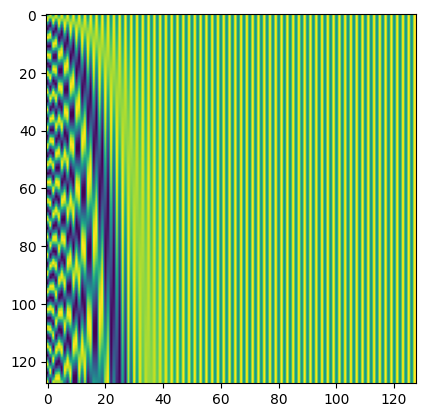

In [75]:
plt.imshow(position_coording_matrix)


# Model Build

In [76]:
device = 'cuda'

In [77]:
class Encoder(torch.nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers):
    super(Encoder, self).__init__()
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.GRU = torch.nn.GRU(self.embedding_size, hidden_size, num_layers)

  def forward(self, x):
    outputs, hidden_state = self.GRU(x)
    return hidden_state

input_size_encoder = len(eng_vocab)
encoder_embedding_size = 1024
hidden_size = 256
num_layers = 2
encoder_lstm = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers).to(device)

In [78]:
class Decoder(torch.nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
    super(Decoder, self).__init__()
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    self.embedding = torch.nn.Embedding(self.input_size, self.embedding_size)
    self.GRU = torch.nn.GRU(self.embedding_size, hidden_size, num_layers)
    self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

  def forward(self, x, hidden_state):
    x = x.unsqueeze(0)
    embedding = self.embedding(x)
    outputs, hidden_state = self.GRU(embedding, hidden_state)
    predictions = self.fc(outputs)
    predictions = predictions.squeeze(0)
    return predictions, hidden_state

input_size_decoder = len(eng_vocab)
decoder_embedding_size = 512
hidden_size = 256
num_layers = 2
output_size = len(eng_vocab)

decoder_lstm = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, num_layers, output_size).to(device)
print(decoder_lstm)

Decoder(
  (embedding): Embedding(26974, 512)
  (GRU): GRU(512, 256, num_layers=2)
  (fc): Linear(in_features=256, out_features=26974, bias=True)
)


In [79]:
class Seq2Seq(torch.nn.Module):
  def __init__(self, Encoder, Decoder):
    super(Seq2Seq, self).__init__()
    self.Encoder = Encoder
    self.Decoder = Decoder

  def forward(self, source, target, tfr=0.5):
    source = source.squeeze(1)
    source = source.transpose(0, 1)
    target = target.transpose(0, 1)
    batch_size = source.shape[1]
    target_len = target.shape[0]
    target_vocab_size = self.Decoder.input_size

    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
    hidden_state_encoder = self.Encoder(source)
    x = target[0,:]
    for i in range(1, target_len):
      output, _ = self.Decoder(x, hidden_state_encoder)
      outputs[i] = output
      best_guess = output.argmax(1)
      x = target[i] if np.random.random() < tfr else best_guess
    return outputs.transpose(0, 1)
  
model = Seq2Seq(encoder_lstm, decoder_lstm).to(device)


# My Realization

# Train

In [80]:
train_pairs = torchdata.datapipes.iter.IterableWrapper(['../Data/1mcorpus/data_train.csv'])
train_pairs = torchdata.datapipes.iter.FileOpener(train_pairs, mode='r', encoding='utf-8', )
train_pairs = train_pairs.parse_csv(skip_lines=1, delimiter=',')
train_pairs = train_pairs.shuffle().map(apply_vocab_transform).map(enum_pair).map(pad_pair).map(oh_encodding_for_predict)
train_dataloader = torch.utils.data.DataLoader(train_pairs, batch_size=128, shuffle=True)
print_simple_data_pipe(train_pairs, f=lambda a: (a[0].shape, a[1].shape, a[2].shape), n=1)

<class 'torch.utils.data.datapipes.iter.callable.MapperIterDataPipe'>
(torch.Size([34]), torch.Size([1, 34, 1024]), torch.Size([34, 26974]))
(torch.Size([34]), torch.Size([1, 34, 1024]), torch.Size([34, 26974]))


In [81]:
d = pd.read_csv('../Data/1mcorpus/data_train.csv')['eng']
w = d.apply(lambda a: len(str(a).split())).value_counts()
w = w / w.max()
torch.tensor(w.to_list()).shape

torch.Size([32])

In [82]:
ev = len(eng_vocab)

In [83]:
loss = torch.nn.CrossEntropyLoss(weight=torch.tensor([0] * 4 + [1]*(ev-4)).to('cuda'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.00000005)

In [84]:
er_list = []

In [85]:
for x_b, y_b, y_b_oh in train_dataloader:
    break
model(y_b.to(device), x_b.to(device))[0]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0997, -0.1602,  0.0972,  ..., -0.1954, -0.2280,  0.2144],
        [-0.1110, -0.1698,  0.0709,  ..., -0.2009, -0.1729,  0.0514],
        ...,
        [-0.0982, -0.1275,  0.0747,  ..., -0.1752, -0.1853,  0.1228],
        [-0.0909, -0.1320,  0.0323,  ..., -0.0532, -0.2105,  0.1386],
        [-0.0181, -0.1588,  0.0340,  ..., -0.1519, -0.1246,  0.0602]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
t=0

In [86]:
epochs = 10
for epoch in range(epochs):
    t = 0
    for x_b, y_b, y_b_oh in train_dataloader:
        # if t == 0:
        #     print(' '.join(eng_vocab.lookup_tokens(x_b[0].to('cpu').numpy())))
        #     print(' '.join(rus_vocab.lookup_tokens(y_b[0].to('cpu').numpy())))
        outputs = model(y_b.to('cuda'), x_b.to('cuda'))
        # print('out')
        optimizer.zero_grad()
        loss_value = loss(outputs.to('cuda').transpose(1, 2).double(), y_b_oh.transpose(1, 2).to('cuda').double())
        # loss_value.backward(retain_graph=True)
        loss_value.backward()
        optimizer.step()
        # optimizer.zero_grad()
        if t > 100: 
            break 
        if t == 0:
            print(' '.join(eng_vocab.lookup_tokens(x_b[0].to('cpu').numpy())))
            # print(' '.join(rus_vocab.lookup_tokens(x_b[0].to('cpu').numpy())))
            print('Out:', ' '.join(eng_vocab.lookup_tokens(outputs[0,:,:].argmax(dim=1).to('cpu').numpy())))
        t+=1

        if t%5==0:
            print(' '.join(eng_vocab.lookup_tokens(x_b[0].to('cpu').numpy())))
            # print(' '.join(rus_vocab.lookup_tokens(x_b[0].to('cpu').numpy())))
            print('Out:', ' '.join(eng_vocab.lookup_tokens(outputs[0,:,:].argmax(dim=1).to('cpu').numpy())))
            print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')
            # print(torch.argmax(outputs[0], dim=1))
        
    er_list.append(loss_value.item())
    print(f'<*>     Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')

[SOS] there ' s a lot of them on ebay . [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Out: [SOS] appearanc july patriotis appearanc july midtronics patriotis battlelog ecstasies appearanc correctl battlelog ecstasies ecstasies ecstasies ecstasies appearanc ecstasies appearanc patriotis ecstasies appearanc patriotis battlelog waited ecstasies ecstasies ecstasies appearanc patriotis battlelog waited correctl
[SOS] it was written with his blood . [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Out: [SOS] spher scarcely crocmint involvement adc balmy gazprom managemen azykh balmy balmy gazprom balmy balmy balmy gazprom azykh aftershocks vince balmy gazprom azykh balmy gazprom azykh balmy gazprom balmy balmy balmy gazprom azykh balmy
Эпоха 1, Значение функции потерь: 1.8380601782628896
[SOS] pe

KeyboardInterrupt: 

In [41]:
t+=1
torch.save(model.state_dict(), f'../Models/S2S{t}.pt')

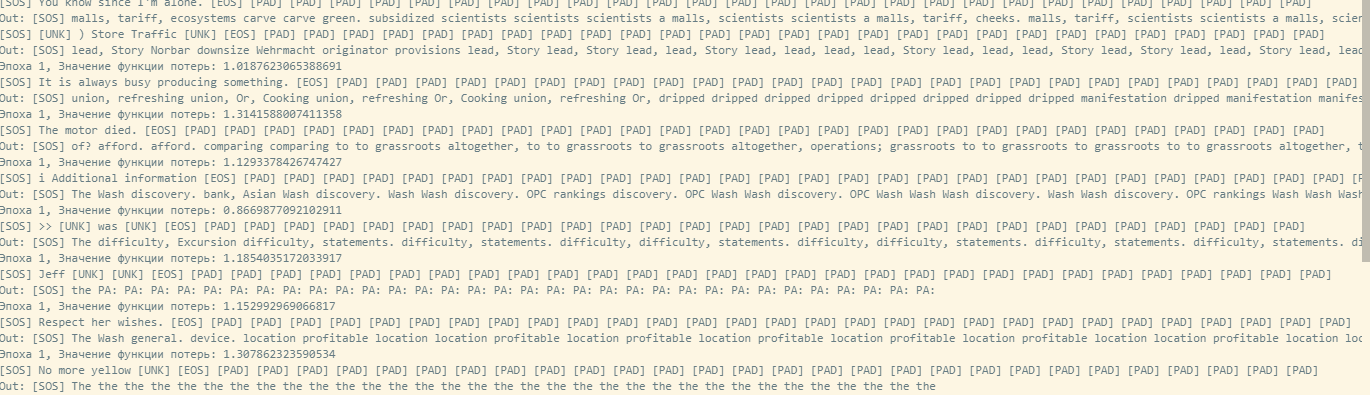

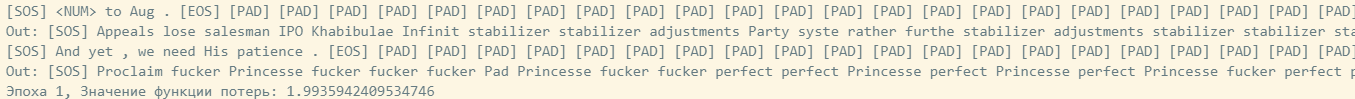

In [44]:
mcheck = Seq2Seq(encoder_lstm, decoder_lstm)
mcheck.load_state_dict(torch.load('../Models/S2S45.pt'))
mcheck.eval()

Seq2Seq(
  (Encoder): Encoder(
    (GRU): GRU(1024, 256, num_layers=2)
  )
  (Decoder): Decoder(
    (embedding): Embedding(35511, 512)
    (GRU): GRU(512, 256, num_layers=2)
    (fc): Linear(in_features=256, out_features=35511, bias=True)
  )
)

Константин Воронцов

In [ ]:
outputs[0, :, :].shape

torch.Size([32, 340627])

In [28]:
def frase_border_add(vocab: torchtext.vocab.Vocab) -> torchtext.transforms.Sequential:
    text_tranform = torchtext.transforms.Sequential(
        torchtext.transforms.AddToken('[SOS]', begin=True),
        torchtext.transforms.AddToken('[EOS]', begin=False),
    )
    return text_tranform


def apply_vocab_transform(pair):
    return (
        frase_border_add(eng_vocab)(pair[0].split()[0:min(len(pair[0]), max_length_sentence-2)]),
        pair[1]
    )

def enumerate_sentence_words(vocab, sentence):
    return [vocab[i] for i in sentence]


def tokenize(sentence):
    return tokenizer([sentence], padding=True, truncation=True, pad_to_multiple_of=max_length_sentence, max_length=max_length_sentence, return_tensors='pt')


def enum_pair(pair):
    return enumerate_sentence_words(eng_vocab, pair[0]), tokenize(pair[1]), pair[1]

def apply_padding(vocab, sentence, max_length_sentence):
    sentence = [sentence, [0 for _ in range(max_length_sentence)]]
    x = (len(sentence[0]), len(sentence[1]))
    sentence = torchtext.transforms.ToTensor(vocab['[PAD]'])(sentence)[0]
    return sentence


def pad_pair(pair):
    with torch.no_grad():
        x = vectorizer(**pair[1])[0]
    return apply_padding(eng_vocab, pair[0], max_length_sentence), x, pair[2]


def oh_encodding_for_predict(pair):
    return pair[0], pair[1], torch.nn.functional.one_hot(pair[0], num_classes=rus_words_num), pair[2]

In [45]:
test_pairs = torchdata.datapipes.iter.IterableWrapper(['../Data/1mcorpus/data_test.csv'])
test_pairs = torchdata.datapipes.iter.FileOpener(test_pairs, mode='r', encoding='utf-8', )
test_pairs = test_pairs.parse_csv(skip_lines=1, delimiter=',')
test_pairs = test_pairs.shuffle().map(apply_vocab_transform).map(enum_pair).map(pad_pair).map(oh_encodding_for_predict)
test_dataloader = torch.utils.data.DataLoader(test_pairs, batch_size=1, shuffle=True)

In [35]:
device = 'cuda'

In [50]:
for x_b, y_b, y_b_oh, y_b_w in test_dataloader:
    print(y_b_w)
    outputs = mcheck(y_b.to(device), x_b.to(device))[0]
    print(' '.join(eng_vocab.lookup_tokens(x_b[0].to('cpu').numpy())))
    print('Out:', ' '.join(eng_vocab.lookup_tokens(outputs.argmax(dim=1).to('cpu').numpy())))
    break

('бюджет заработной платы сотрудника;',)
[SOS] the user ' s salary budget ; [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Out: [SOS] Uniqueness Panoram furthe FARM Ric Uniqueness Panoram . Kids minimum Garage Garage . Garage . . . Garage . . . Garage Garage . . . Garage Garage Garage Garage . . Garage


Панорама уникальности далее FARM Ric Панорама уникальности. Минимальный детский гараж``

# D U

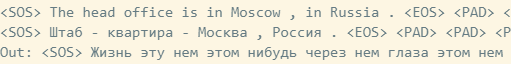

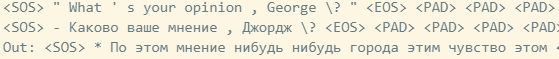

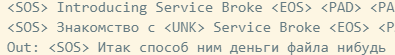

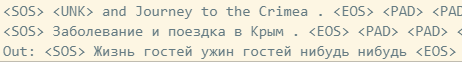

# D U Attention

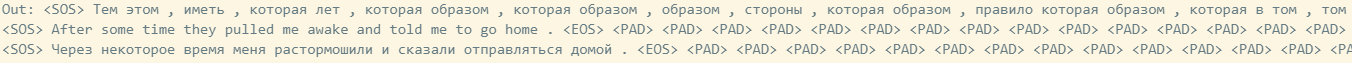